In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Definimos el kernel cuadrático exponencial (SE)
def kernel_se(x1, x2, length_scale=1.0, sigma_f=1.0):
    sqdist = np.subtract.outer(x1, x2)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

In [3]:
# Definimos la función de log-verosimilitud marginal (Negative Log Marginal Likelihood)
def nlml(params, x_train, y_train, noise=1e-6):
    length_scale, sigma_f, sigma_n = params
    K = kernel_se(x_train, x_train, length_scale, sigma_f) + sigma_n**2 * np.eye(len(x_train))
    L = np.linalg.cholesky(K + noise * np.eye(len(x_train)))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    nlml_value = 0.5 * y_train.T @ alpha + np.sum(np.log(np.diagonal(L))) + 0.5 * len(x_train) * np.log(2 * np.pi)
    return nlml_value


In [4]:
# Generamos datos de entrenamiento
np.random.seed(42)
x_train = np.linspace(-3, 3, 20)
y_train = np.sin(x_train) + 0.1 * np.random.randn(len(x_train))

In [5]:
# Inicializamos hiperparámetros
initial_params = [1.0, 1.0, 0.1]  # length_scale, sigma_f, sigma_n

In [6]:
# Optimizamos los hiperparámetros
result = minimize(nlml, initial_params, args=(x_train, y_train), bounds=((1e-2, None), (1e-2, None), (1e-6, None)))
optimal_params = result.x
length_scale_opt, sigma_f_opt, sigma_n_opt = optimal_params

In [7]:
print(f"Optimal length scale: {length_scale_opt:.4f}")
print(f"Optimal sigma_f: {sigma_f_opt:.4f}")
print(f"Optimal sigma_n: {sigma_n_opt:.4f}")

Optimal length scale: 1.7764
Optimal sigma_f: 1.0102
Optimal sigma_n: 0.0804


In [8]:
# Predicción posterior
x_test = np.linspace(-3.5, 3.5, 100)
K_train = kernel_se(x_train, x_train, length_scale_opt, sigma_f_opt) + sigma_n_opt**2 * np.eye(len(x_train))
K_s = kernel_se(x_train, x_test, length_scale_opt, sigma_f_opt)
K_ss = kernel_se(x_test, x_test, length_scale_opt, sigma_f_opt)

K_train_inv = np.linalg.inv(K_train)

mu = K_s.T @ K_train_inv @ y_train
cov = K_ss - K_s.T @ K_train_inv @ K_s

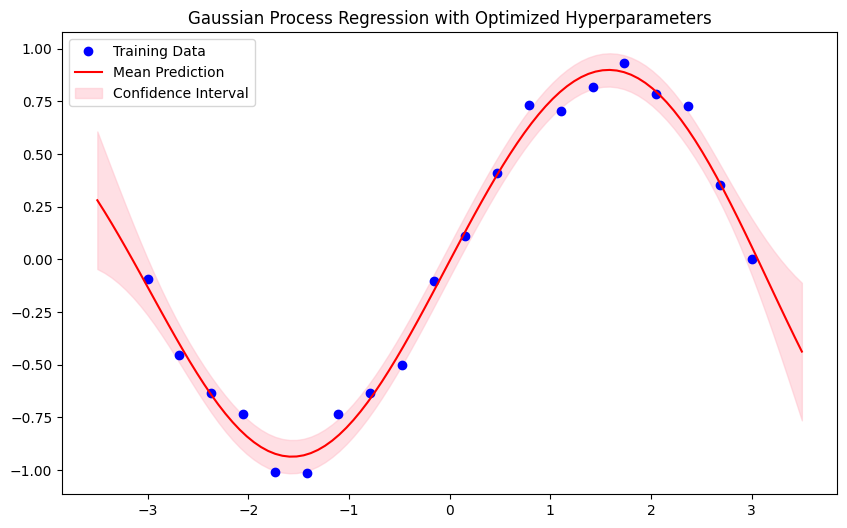

In [9]:
# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'bo', label="Training Data")
plt.plot(x_test, mu, 'r', label="Mean Prediction")
plt.fill_between(x_test, mu - 2 * np.sqrt(np.diag(cov)), mu + 2 * np.sqrt(np.diag(cov)), color='pink', alpha=0.5, label="Confidence Interval")
plt.title("Gaussian Process Regression with Optimized Hyperparameters")
plt.legend()
plt.show()